In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# DATASET 
import kagglehub


path = kagglehub.dataset_download("arjunbhasin2013/ccdata")

print("Path to dataset files:", path)

In [2]:
data = pd.read_csv('../clustering/CC General.csv', sep = ',')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

### Чистка данных

In [4]:
min_limit = data[data['TENURE'] == 6]['CREDIT_LIMIT'].min()

In [5]:
#Обнаружены нулевые значения в CREDIT_LIMIT, MINIMUM_PAYMENTS
data['CREDIT_LIMIT'].fillna(min_limit, inplace=True)
data['MINIMUM_PAYMENTS'].fillna(data['PAYMENTS'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

<Figure size 800x550 with 0 Axes>

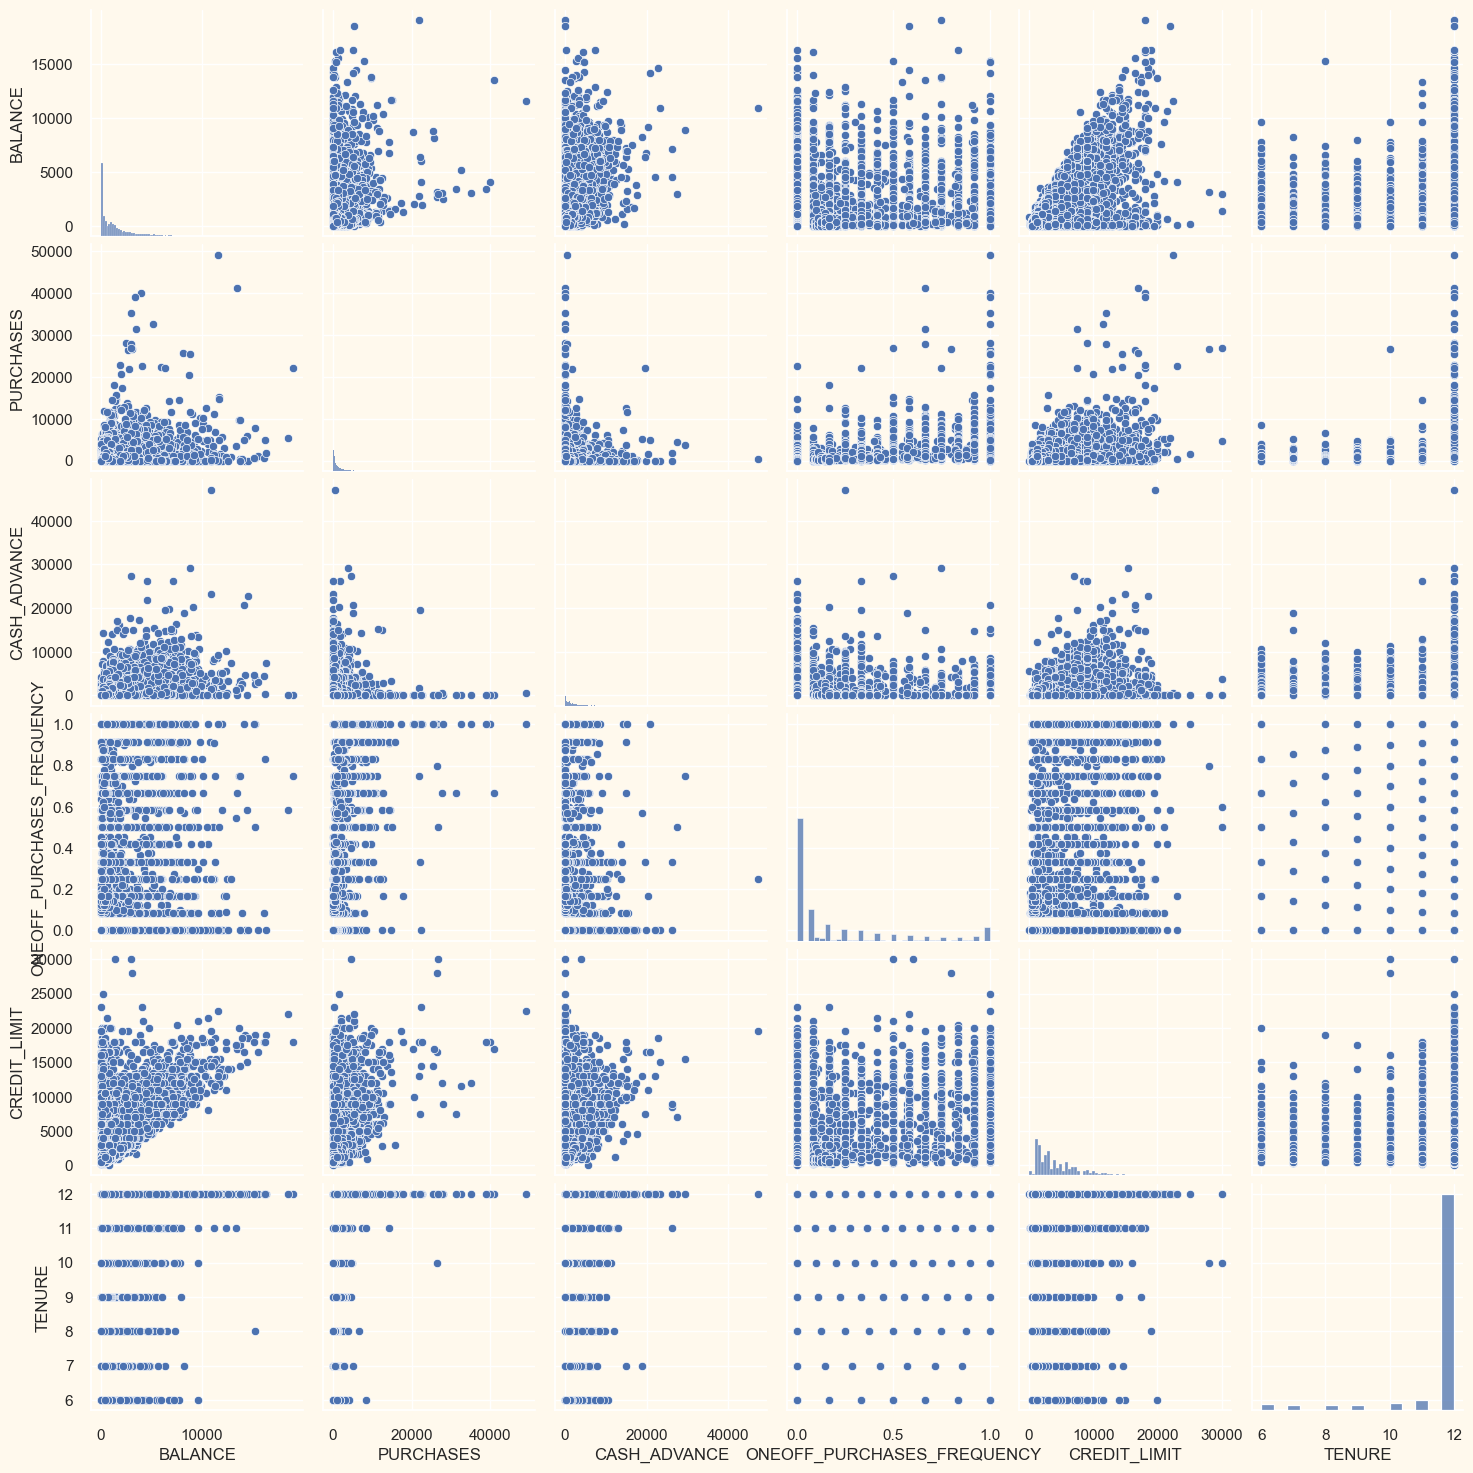

In [6]:
#Поиск выбросов с помощью визуализации наиболее важных переменных
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = ["BALANCE", "PURCHASES", "CASH_ADVANCE", "ONEOFF_PURCHASES_FREQUENCY", "CREDIT_LIMIT", "TENURE"]
plt.figure()
sns.pairplot(data[To_Plot], palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [7]:
#С помощью визуального анализа найдены выбросы в CASH_ADVANCE, BALANCE, PURCHASES
data.drop(data[data.BALANCE > 18000].index, inplace=True)
data.drop(data[data.PURCHASES == max(data.PURCHASES)].index, inplace=True)
data.drop(data[data.CASH_ADVANCE > 30000].index, inplace=True)
len(data)

8946

<Axes: >

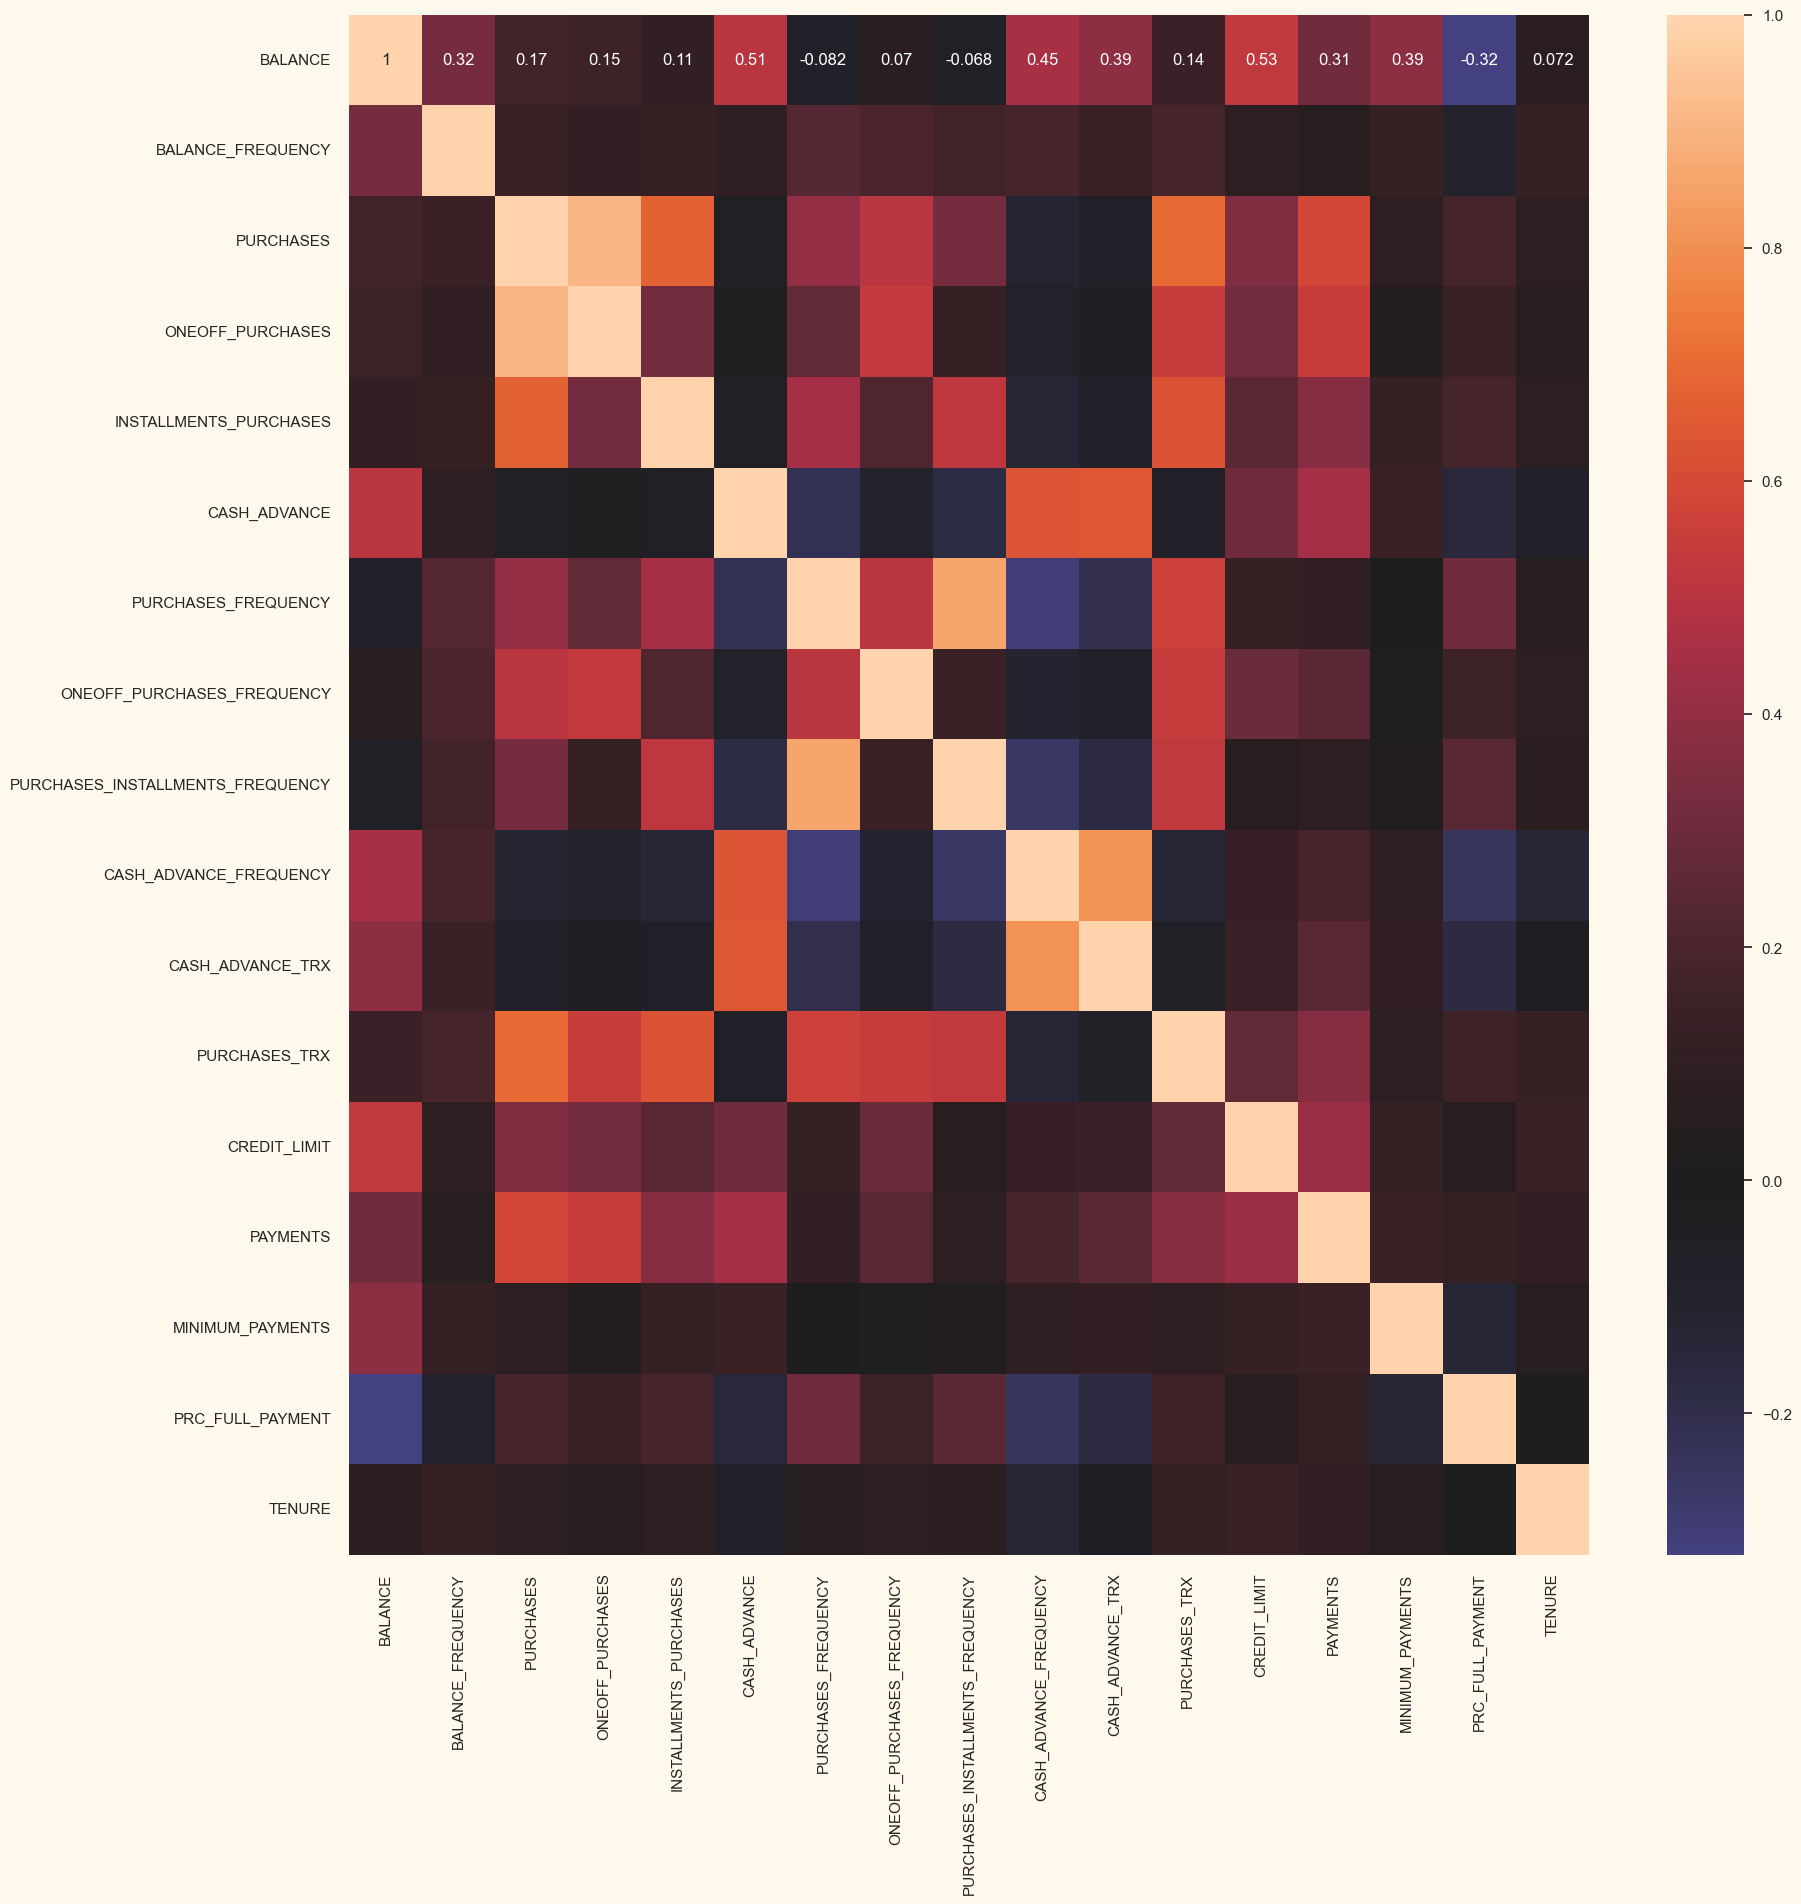

In [8]:
corrmat = data.iloc[:, 1:].corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, center=0)

### Preprocessing

In [9]:
data_normal = data.iloc[:, 1:].copy(deep=True)
data_normal

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.000000,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,275.861322,0.000000,6
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


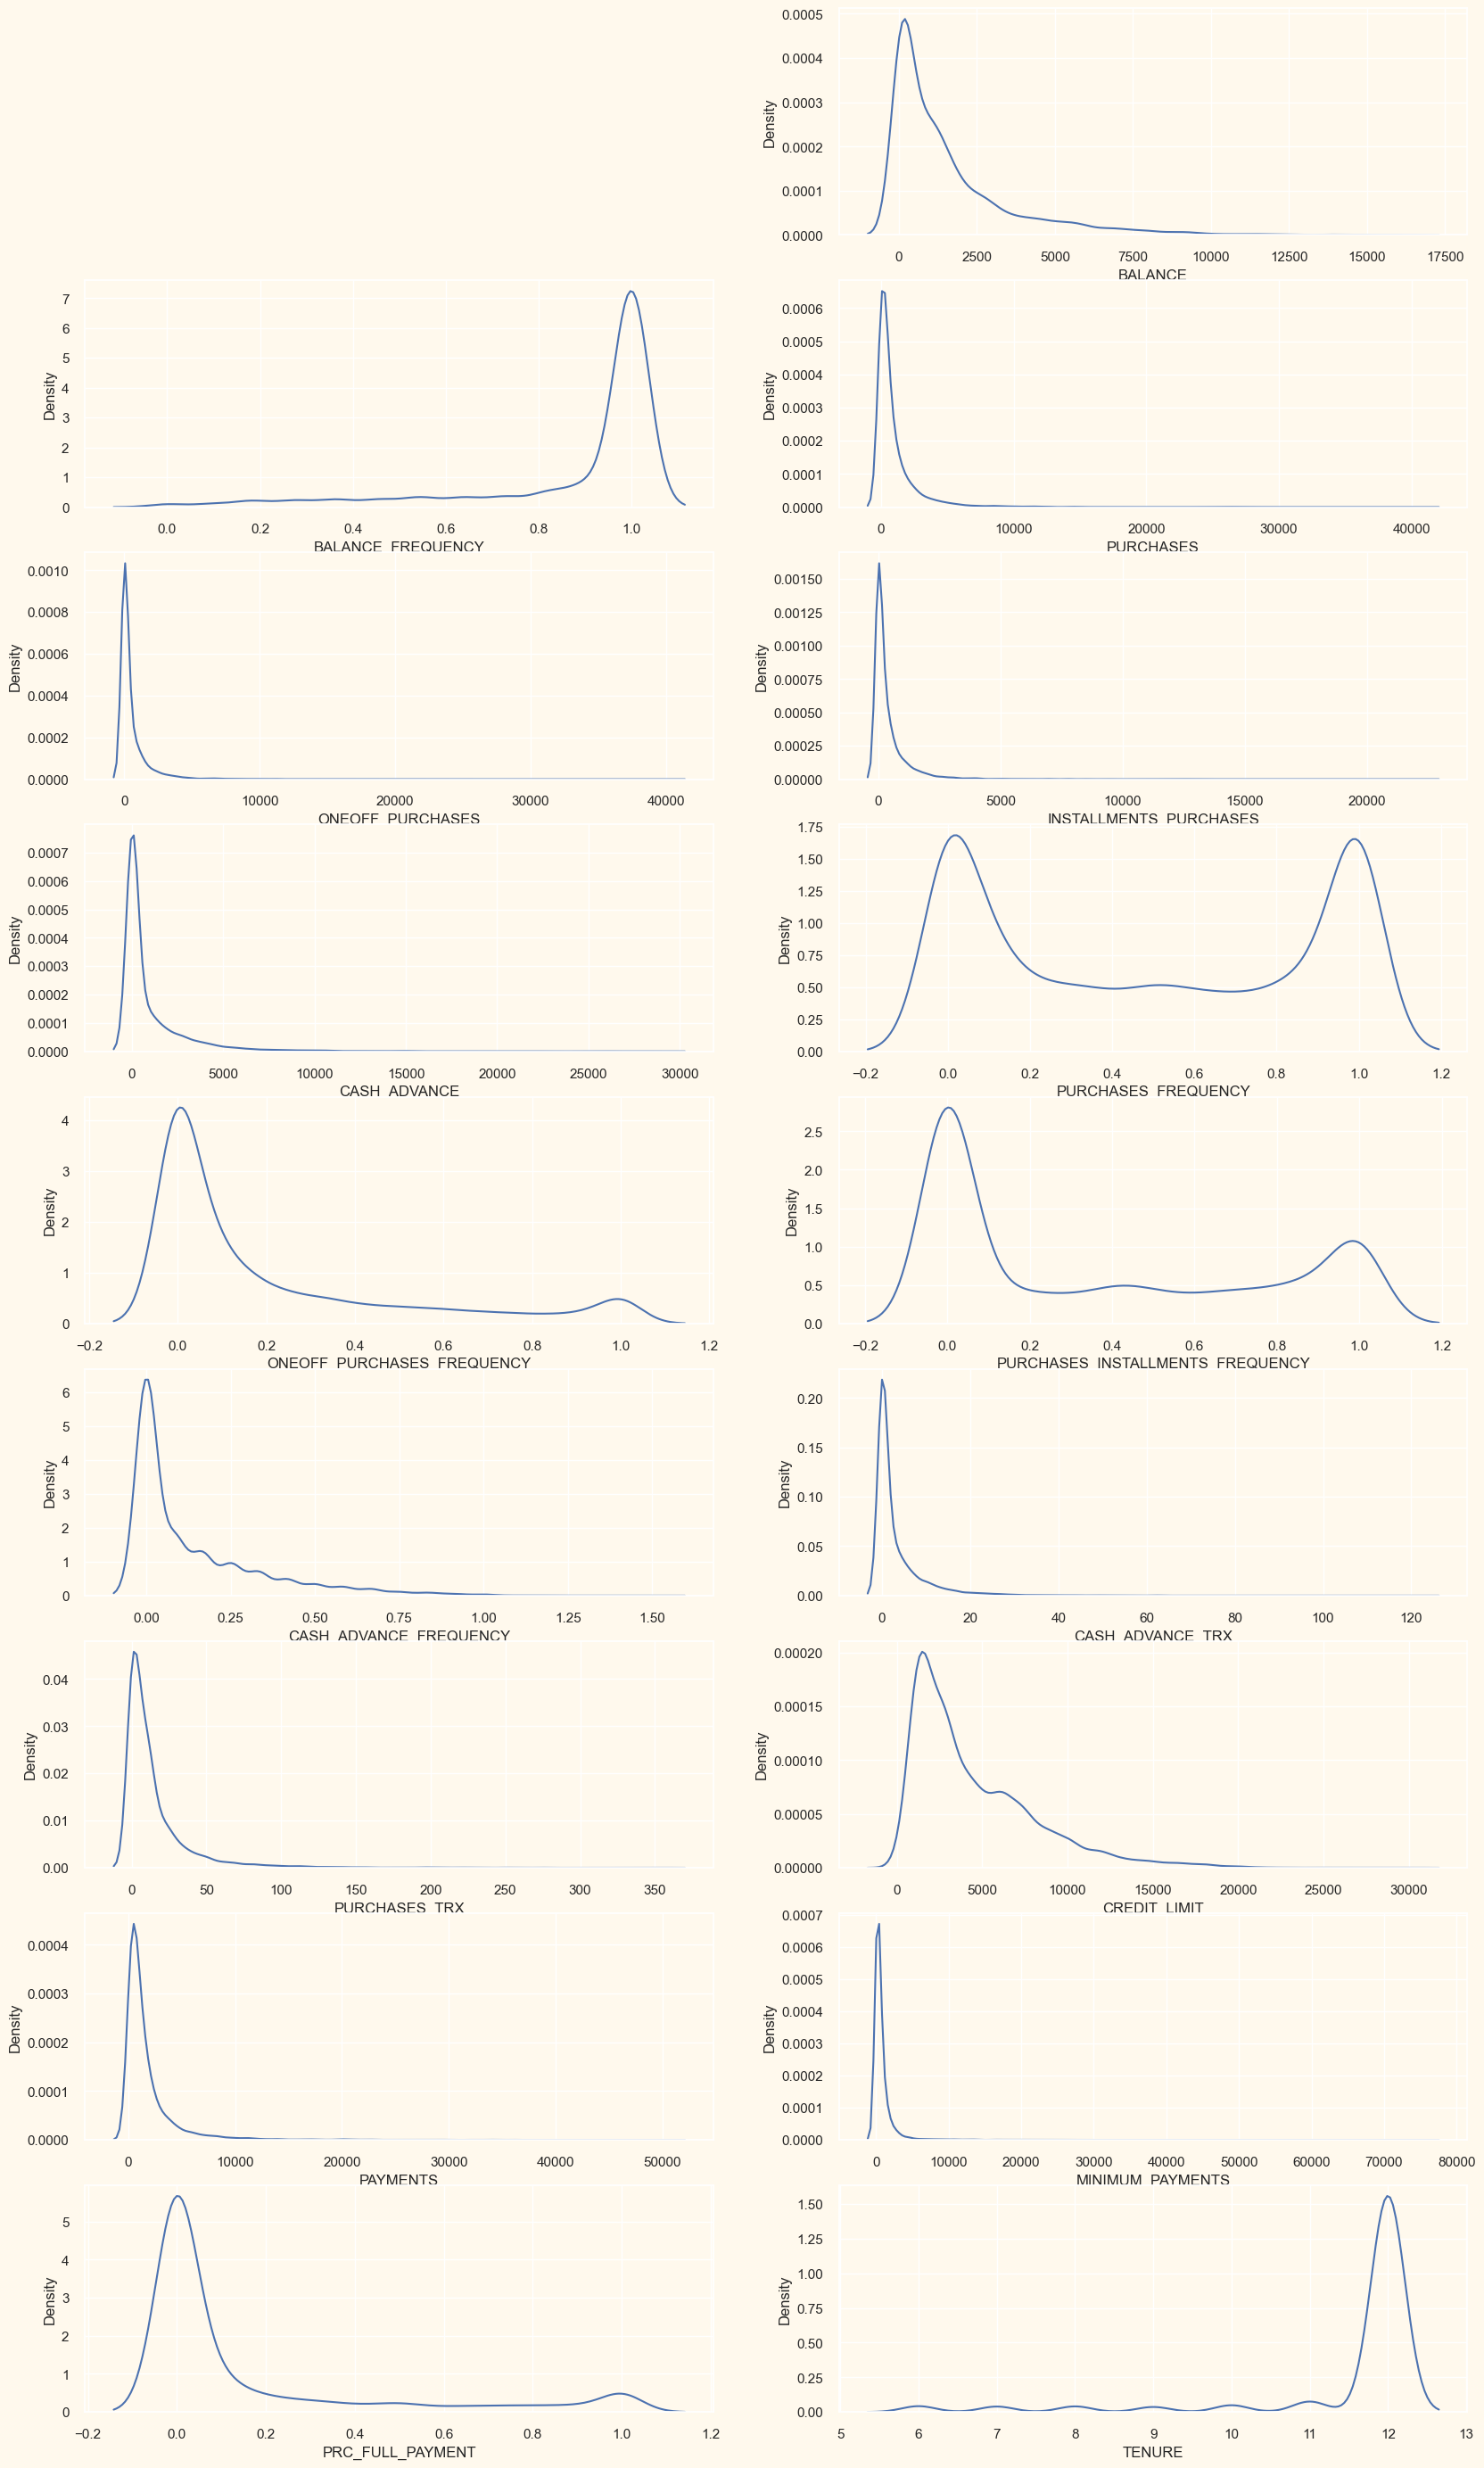

In [10]:
# посмотрим на распределение данных, чтобы выбрать способ преобразования данных : нормализацию или станартизацию
plt.figure(figsize=(20,35))
for i, clmn in enumerate(data.columns):
    if data[clmn].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(data[clmn], ax=ax)
        plt.xlabel(clmn)
        
plt.show()

##### Нормализуем данные для реализации метода K-means, данные не имеют нормального распределения, поэтому предпочтение стандартизации не отдается

In [11]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
d_n = Scaler.fit_transform(data_normal)
data_normalized = pd.DataFrame(d_n ,columns = data_normal.columns)
data_normalized

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002508,0.818182,0.002324,0.000000,0.004240,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.196411,0.909091,0.000000,0.000000,0.000000,0.220030,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014035,0.222222,1.0
2,0.153031,1.000000,0.018835,0.019032,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.102219,0.636364,0.036516,0.036899,0.000000,0.007028,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0
4,0.050151,1.000000,0.000390,0.000394,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8941,0.001748,1.000000,0.007092,0.000000,0.012939,0.000000,1.000000,0.000000,0.833333,0.000000,0.00000,0.016760,0.031720,0.006419,0.000640,0.500000,0.0
8942,0.001177,1.000000,0.007308,0.000000,0.013333,0.000000,1.000000,0.000000,0.833333,0.000000,0.00000,0.016760,0.031720,0.005439,0.003610,0.000000,0.0
8943,0.001435,0.833333,0.003518,0.000000,0.006418,0.000000,0.833333,0.000000,0.666667,0.000000,0.00000,0.013966,0.031720,0.001602,0.001079,0.250000,0.0
8944,0.000825,0.833333,0.000000,0.000000,0.000000,0.001249,0.000000,0.000000,0.000000,0.111111,0.01626,0.000000,0.015025,0.001036,0.000730,0.250000,0.0


In [12]:
# Используем метод PCA для преобразование данных в трехмерное пространство для последнующей визуализации
pca = PCA(n_components=2)
pca.fit(data_normalized)
PCA_data = pd.DataFrame(pca.transform(data_normalized), columns=(["col1","col2"]))
PCA_data.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,8946.0,-4.914468e-17,0.573692,-0.767407,-0.590965,-0.078799,0.581147,1.297627
col2,8946.0,-2.859327e-17,0.305988,-0.769830,-0.214935,-0.010784,0.137195,1.097593


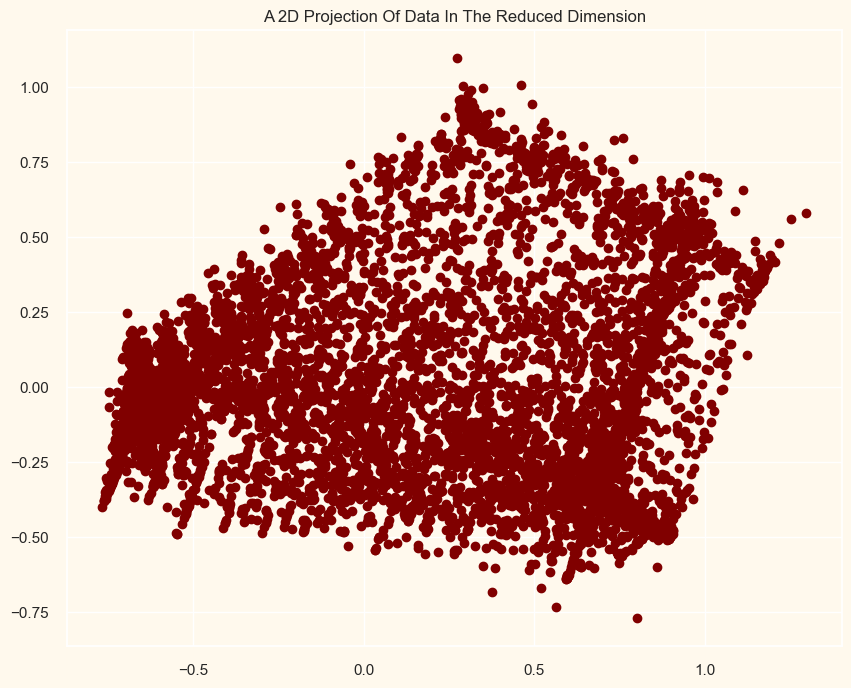

In [13]:
x = PCA_data["col1"]
y = PCA_data["col2"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.scatter(x,y, c="maroon", marker="o" )
ax.set_title("A 2D Projection Of Data In The Reduced Dimension")
plt.show()

### Кластеризация с KMeans

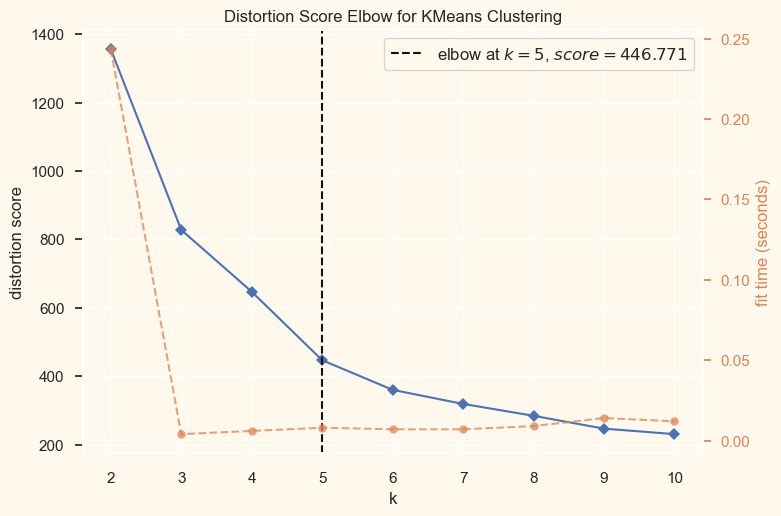

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# Так как KMeans требует заранее известного кол-во кластеров, найдем оптимальное число с помощью "Метода локтя"
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_data)
Elbow_M.show()

In [15]:
kmeans_clustering = KMeans(n_clusters = 5)
kmeans_clustering.fit(PCA_data)
Cluster_KM = kmeans_clustering.labels_
Cluster_KM

array([1, 1, 2, ..., 4, 1, 0])

In [16]:
df_clus = pd.DataFrame(data=Cluster_KM)
df_clus.value_counts(normalize=True)

1    0.410463
4    0.221440
3    0.142857
2    0.129555
0    0.095685
Name: proportion, dtype: float64

In [17]:
PCA_data_KM =  PCA_data.copy(deep=True)
PCA_data_KM['Cluster_label'] = Cluster_KM

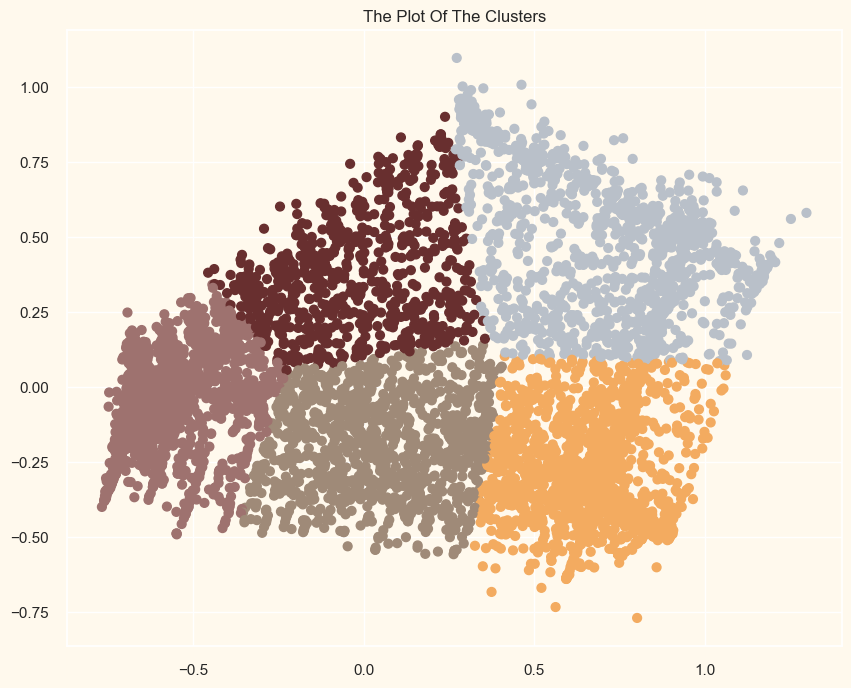

In [18]:
#Визуализируем кластеры
fig = plt.figure(figsize=(10,8))
ax = plt.subplot()
ax.scatter(x, y, s=40, c=PCA_data_KM["Cluster_label"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

In [19]:
# Оценим кластеризацию с помощью метрики "силуэтный коэффициент"
score = silhouette_score(PCA_data, kmeans_clustering.labels_)
score

0.5328888683329923

##### Оценим силуэтный коэффициент при разном количестве кластеров для гибкости в подборе маркетинговой стратегии

In [20]:
n_clust = range(2, 11)
for i in n_clust:
    kmeans_clustering_iter = KMeans(n_clusters = i)
    kmeans_clustering_iter.fit(PCA_data)
    c_labels = kmeans_clustering.labels_
    print(f'Силуэтный коэффициент для {i} кластеров равен {silhouette_score(PCA_data, kmeans_clustering_iter.labels_)}')

Силуэтный коэффициент для 2 кластеров равен 0.5730191739230376
Силуэтный коэффициент для 3 кластеров равен 0.5748700026299037
Силуэтный коэффициент для 4 кластеров равен 0.5217434918323428
Силуэтный коэффициент для 5 кластеров равен 0.5393559799066643
Силуэтный коэффициент для 6 кластеров равен 0.43311961650347813
Силуэтный коэффициент для 7 кластеров равен 0.3945638274308456
Силуэтный коэффициент для 8 кластеров равен 0.5006884871446938
Силуэтный коэффициент для 9 кластеров равен 0.44687308385691127
Силуэтный коэффициент для 10 кластеров равен 0.44061066187095604


##### Следовательно, оптимальное количество кластеров по метрике "силуэтный коэффициент" равно 3

In [21]:
clustering_best = KMeans(n_clusters=3).fit(PCA_data)
KMeans_best = PCA_data.copy(deep=True)
KMeans_best['Clust_label'] = clustering_best.labels_

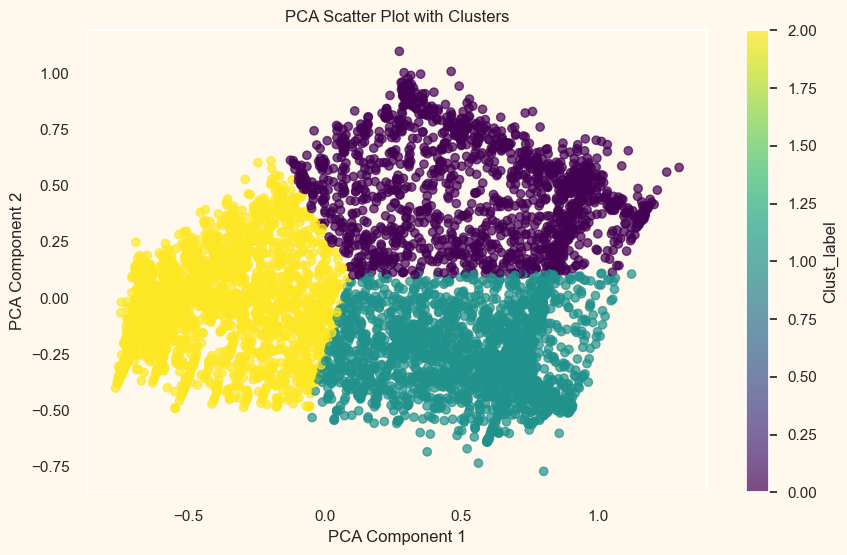

In [22]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(KMeans_best['col1'], KMeans_best['col2'], c=KMeans_best['Clust_label'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Clust_label')
plt.title('PCA Scatter Plot with Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

### Агломеративная кластеризация

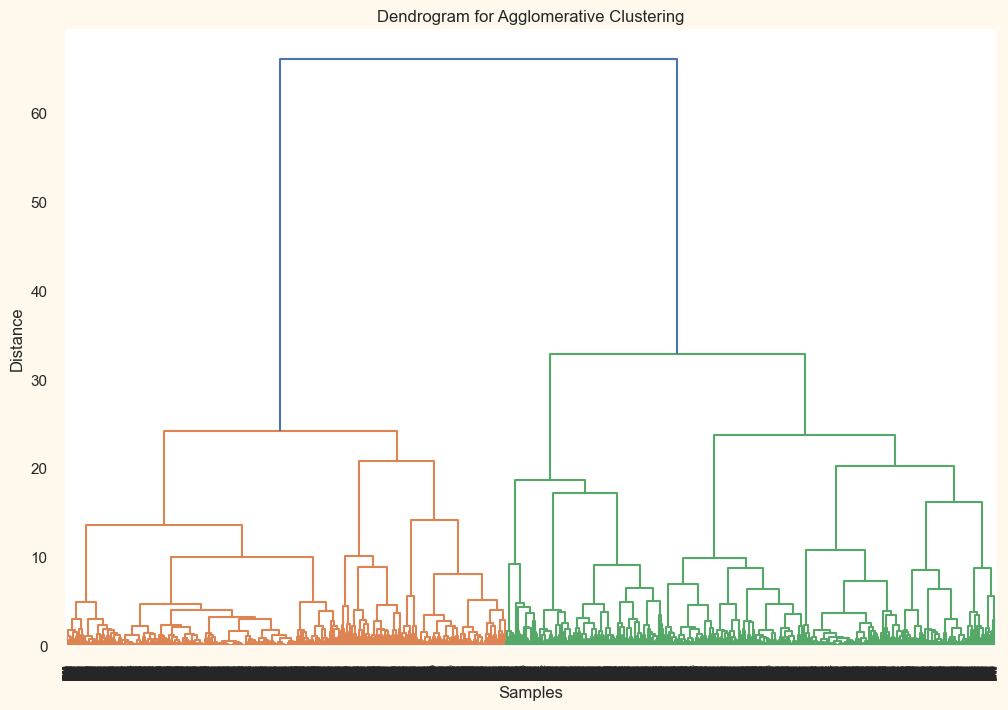

In [23]:
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(data_normalized, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [24]:
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clustering.fit_predict(data_normalized)
data_Agg = data_normalized.copy(deep=True)
data_Agg['cluster_Agg'] = agg_labels

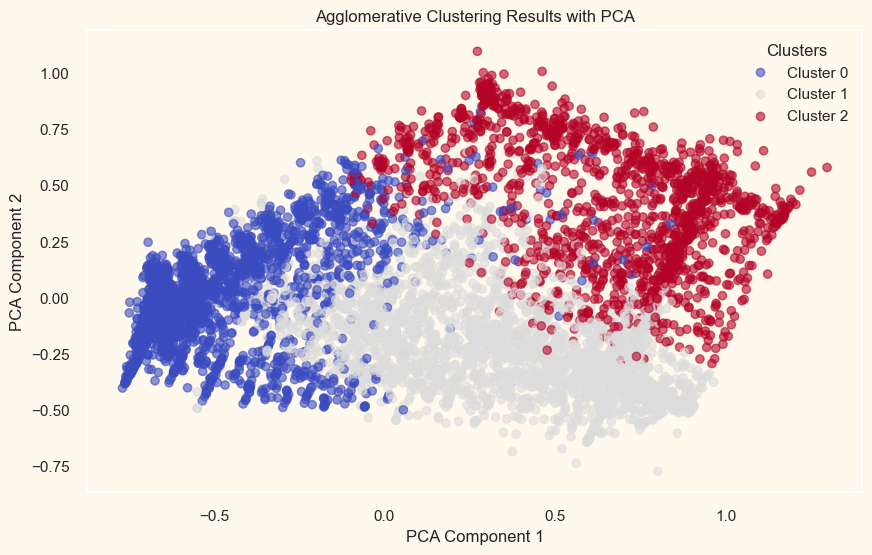

In [25]:
pca_Agg = PCA(n_components=2)
pca_Agg_data = pca.fit_transform(data_normalized)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_Agg_data[:, 0], pca_Agg_data[:, 1], c=agg_labels, cmap='coolwarm', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Agglomerative Clustering Results with PCA')
legend_labels = [f'Cluster {i}' for i in range(3)]
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels, title="Clusters")
plt.grid()
plt.show()

In [26]:
score = silhouette_score(data_Agg.iloc[:, :-1], agg_labels)
score

0.29136133910571904

### DBSCAN

In [27]:
data_dbscan = data_normalized.copy(deep=True)

In [28]:
dbscan = DBSCAN()
scorer = make_scorer(silhouette_score)
# Задаем параметры для поиска
param_grid = {
    'eps': [0.3, 0.4, 0.5],
    'min_samples': [3, 5, 7],
}

# Создаем GridSearchCV
grid_search = GridSearchCV(dbscan, param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Обучаем модель
grid_search.fit(data_dbscan)  # X - ваши данные

# Лучшие параметры
print(grid_search.best_params_)

{'eps': 0.3, 'min_samples': 3}


In [29]:
dbscan_best = DBSCAN(eps=0.3, min_samples=3)
dbscan_labels = dbscan.fit_predict(data_normalized)
data_dbscan['Clusters_dbscan'] = dbscan_labels
score = silhouette_score(data_dbscan.iloc[:, :-1], dbscan_labels)
score

0.339306099509962

In [30]:
pca_dbscan = PCA(n_components=2)
pca_dbscan_result = pca.fit_transform(data_dbscan)
pca_dbscan_result

array([[-0.48060192, -0.10046338],
       [-0.61205968, -0.01682256],
       [ 0.30439209,  0.91528251],
       ...,
       [ 0.36179672, -0.43056199],
       [-0.64424826, -0.22456052],
       [-0.09330158,  0.38112595]])

##### Вывод: Алгоритм KMeans является наиболее эффективным для кластеризации данного датасета согласно метрике "силуэтный анализ" и визуальному анализу представления кластеров

### Анализ распределения кластеров

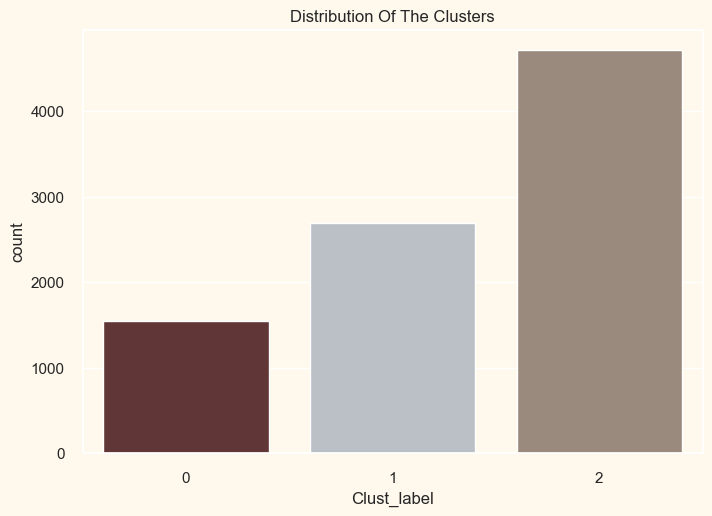

In [31]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=KMeans_best["Clust_label"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [32]:
data_to_analyze = data_normal.copy(deep=True)
data_to_analyze['Cluster'] = clustering_best.labels_

In [33]:
cluster0 = data_to_analyze[data_to_analyze.Cluster == 0].copy(deep=True)
cluster1 = data_to_analyze[data_to_analyze.Cluster == 1].copy(deep=True)
cluster2 = data_to_analyze[data_to_analyze.Cluster == 2].copy(deep=True)

In [34]:
for i in range(3):
    cluster_name = f"cluster{i}"  # Создаем имя переменной
    print(cluster_name)
    print(f"{cluster_name} mean purchases amount =", (globals()[cluster_name]['PURCHASES'].mean())) 
    print(f"{cluster_name} mean balance =", (globals()[cluster_name]['BALANCE'].mean()))
    print(f"{cluster_name} mean credit limit =", (globals()[cluster_name]['CREDIT_LIMIT'].mean()), end = '\n'*3)

cluster0
cluster0 mean purchases amount = 3088.1093839169907
cluster0 mean balance = 2027.0661737853438
cluster0 mean credit limit = 6651.867114726978


cluster1
cluster1 mean purchases amount = 1018.551109043543
cluster1 mean balance = 1015.77474735802
cluster1 mean credit limit = 3828.969542841831


cluster2
cluster2 mean purchases amount = 297.47764680941276
cluster2 mean balance = 1714.423500246131
cluster2 mean credit limit = 4153.828254990037


